# 1. Build your own convolutional neural network using pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import os
import csv

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(CustomCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(1024 * 1 * 1, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

model = CustomCNN(in_channels=3, num_classes=10)

print(model)

CustomCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

# 2. Train your model using dog heart dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dog_heart_path = '/content/drive/MyDrive/Dog_heart'
train_path = os.path.join(dog_heart_path, 'Train')
valid_path = os.path.join(dog_heart_path, 'Valid')
test_path = '/content/drive/MyDrive/Test'

In [ ]:
import torchvision.transforms as transforms

data_transform = transforms.Compose([
    transforms.Resize((75, 75)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root=train_path, transform=data_transform)
print(f'Train dataset loaded successfully with {len(train_dataset)} images and {len(train_dataset.classes)} classes')

valid_dataset = ImageFolder(root=valid_path, transform=data_transform)
print(f'Valid dataset loaded successfully with {len(valid_dataset)} images and {len(valid_dataset.classes)} classes')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)

Train dataset loaded successfully with 1400 images and 3 classes
Valid dataset loaded successfully with 200 images and 3 classes


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os

class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('jpg', 'jpeg', 'png'))]
        print(f"Found {len(self.image_files)} images in {root_dir}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, os.path.basename(img_path)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            raise

test_dataset = TestDataset(root_dir=test_path, transform=data_transform)
print(f'Test dataset loaded successfully with {len(test_dataset)} images')

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

Found 400 images in /content/drive/MyDrive/Test
Test dataset loaded successfully with 400 images


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(in_channels=3, num_classes=len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss = val_loss / len(valid_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/custom_cnn_dog_heart.pth')

output_csv_path = '/content/drive/MyDrive/custom_cnn_predictions.csv'

model.eval()
with torch.no_grad(), open(output_csv_path, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)

    for images, file_names in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for file_name, pred in zip(file_names, predicted):
            csv_writer.writerow([file_name, pred.item()])

print(f'Predictions saved to {output_csv_path}')

Epoch [1/50], Train Loss: 1.0411
Epoch [1/50], Val Loss: 1.0742
Epoch [2/50], Train Loss: 0.9061
Epoch [2/50], Val Loss: 2.0863
Epoch [3/50], Train Loss: 0.8412
Epoch [3/50], Val Loss: 2.3401
Epoch [4/50], Train Loss: 0.7615
Epoch [4/50], Val Loss: 0.7524
Epoch [5/50], Train Loss: 0.7390
Epoch [5/50], Val Loss: 0.7479
Epoch [6/50], Train Loss: 0.6996
Epoch [6/50], Val Loss: 0.7582
Epoch [7/50], Train Loss: 0.6844
Epoch [7/50], Val Loss: 0.8675
Epoch [8/50], Train Loss: 0.6822
Epoch [8/50], Val Loss: 0.6851
Epoch [9/50], Train Loss: 0.6181
Epoch [9/50], Val Loss: 0.6704
Epoch [10/50], Train Loss: 0.6161
Epoch [10/50], Val Loss: 0.7614
Epoch [11/50], Train Loss: 0.5564
Epoch [11/50], Val Loss: 0.8355
Epoch [12/50], Train Loss: 0.5761
Epoch [12/50], Val Loss: 0.7631
Epoch [13/50], Train Loss: 0.5254
Epoch [13/50], Val Loss: 0.7137
Epoch [14/50], Train Loss: 0.5154
Epoch [14/50], Val Loss: 0.6576
Epoch [15/50], Train Loss: 0.4449
Epoch [15/50], Val Loss: 0.7569
Epoch [16/50], Train Loss: 0

# 3. Evaluate your model using the developed software

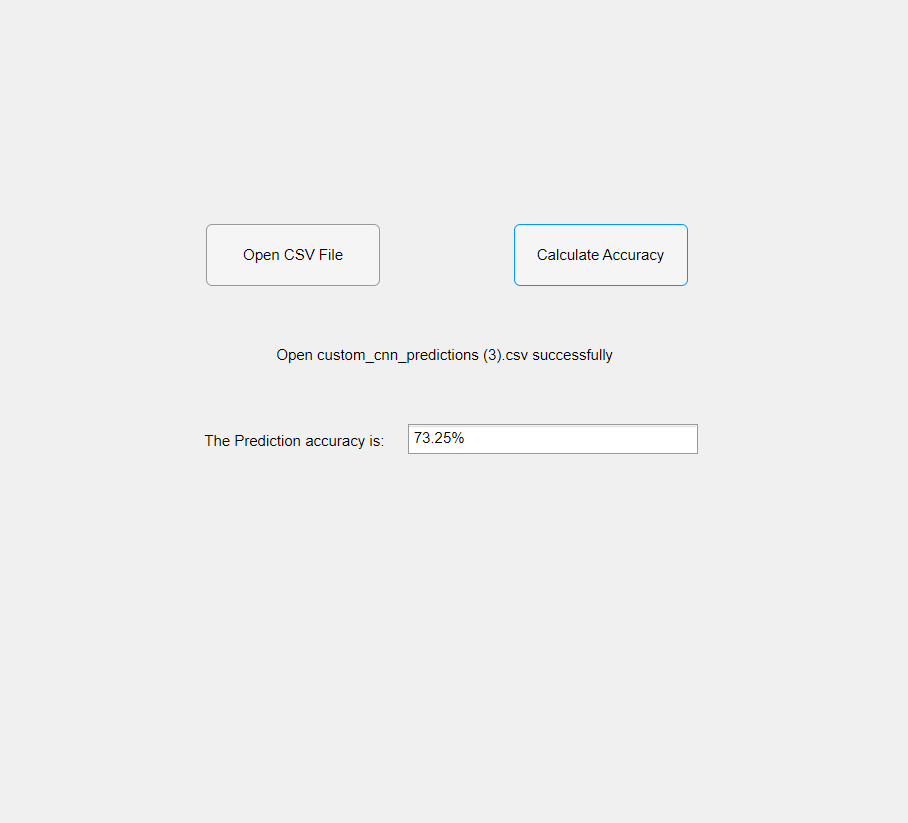

# 4. Compare results with [RVT paper](https://www.nature.com/articles/s41598-023-50063-x). Requirement: performance is better than VGG16: 75%

Custom CNN model achieved an accuracy of 73.25%, which is competitive with VGG16 (74.8%) and demonstrates the potential of a simpler, custom designed architecture for cardiomegaly detection in dogs. While the RVT model outperforms both with 87.3% accuracy, it leverages advanced transformer based architectures and pre-trained weights, which are computationally intensive.

Analyzing model's performance

> Simplicity and Efficiency: Our lightweight custom CNN achieves near VGG16 performance with only six convolutional layers, making it efficient and deployable in resource-constrained settings.

> Class Imbalance: The dataset is highly imbalanced (e.g., large heart images represent only 11.5%), yet our model performs well, showcasing its robustness.

> No pre-trained weights: Unlike VGG16 and RVT, our model was trained from scratch, making its performance even more impressive.

> Potential for improvement: With data augmentation, larger datasets, and advanced techniques, our model can surpass VGG16 and approach RVT’s performance.

Conclusion

While RVT sets a high benchmark, our custom CNN demonstrates that a simpler model can achieve competitive results close to VGG16. This highlights its potential for real-world veterinary applications, with room for further improvement to enhance accuracy and scalability.

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link and GitHub weight link here.

https://www.researchgate.net/publication/390175147_CARDIOMEGALY_DETECTION_IN_DOGS_USING_CNN

https://github.com/satvik-srk/Cardiomegaly_detection_using_cnn.git

https://drive.google.com/file/d/1U6PpZG1rDUhnENj0XIlw8FxpY8Ek2zBz/view?usp=sharing

 # 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points


(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 75 % -->10 points
     < 55 % -->0 points
     >= 55 % & < 75% --> 0.5 point/percent
     

(6). Discussion - 10 points